In [31]:
import sys
from typing import List, Tuple, Any, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../..')
from utils import set_seed, plot_gantt

# Set random seed for reproducibility
set_seed(42)

In [32]:
# Load the scheduling data from CSV
schedules_df = pd.read_csv('../../data/schedules.csv')
processing_times = schedules_df['processing_time'].values
release_dates = schedules_df['release_date'].values
n_jobs = len(schedules_df)
print(f"Loaded {n_jobs} jobs")
schedules_df.head()

Loaded 100 jobs


,processing_time,release_date
0,62,0
1,47,1
2,66,2
3,88,4
4,44,18


In [33]:
class AntColonyScheduling(object):
    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray, n_ants: int, n_best: int, n_iterations: int, decay: float, alpha: float = 1, beta: float = 1) -> None:
        """
        Initialize the Ant Colony class for scheduling.

        Args:
            processing_times (np.ndarray): Processing times for each job.
            release_dates (np.ndarray): Release dates for each job.
            n_ants (int): Number of ants.
            n_best (int): Number of best paths selected per generation.
            n_iterations (int): Number of iterations.
            decay (float): Evaporation rate for pheromone.
            alpha (float, optional): Importance of pheromone. Defaults to 1.
            beta (float, optional): Importance of visibility. Defaults to 1.
        """
        self.processing_times = processing_times
        self.release_dates = release_dates
        self.n_jobs = len(processing_times)
        self.pheromone = np.ones((self.n_jobs, self.n_jobs)) / self.n_jobs
        self.visibility = 1 / (processing_times + 1e-10)
        self.all_indexes = range(self.n_jobs)
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self) -> Tuple[Any, List[float]]:
        """ Run the Ant Colony algorithm for scheduling """
        shortest_schedule = None
        all_time_shortest = ("placeholder", np.inf)
        cost_list = []
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheromone(all_paths, self.n_best, shortest_schedule)
            shortest_schedule = min(all_paths, key=lambda x: x[1])
            cost_list.append(shortest_schedule[1])
            if shortest_schedule[1] < all_time_shortest[1]:
                all_time_shortest = shortest_schedule
            self.pheromone *= self.decay
        return all_time_shortest, cost_list

    def spread_pheromone(self, all_paths: List[Tuple[Any, float]], n_best: int, shortest_schedule: Any) -> None:
        """ Spread pheromone """
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / dist
        if shortest_schedule is not None:
            for move in shortest_schedule[0]:
                self.pheromone[move] += 1.0 / shortest_schedule[1]

    def gen_path_dist(self, path: List[Tuple[int, int]]) -> float:
        """ Calculate makespan for the schedule """
        sequence = [path[0][0]] + [move for prev, move in path]
        current_time = 0
        for job in sequence:
            start = max(current_time, self.release_dates[job])
            current_time = start + self.processing_times[job]
        return current_time

    def gen_all_paths(self) -> List[Tuple[Any, float]]:
        """ Generate all ants' paths """
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start: int) -> List[Tuple[int, int]]:
        """ Generate a path (sequence of jobs) """
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(self.n_jobs - 1):
            move = self.pick_move(self.pheromone[prev], self.visibility, visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        return path

    def pick_move(self, pheromone: np.ndarray, visibility: np.ndarray, visited: Set[int]) -> int:
        """ Choose next move """
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0
        row = pheromone ** self.alpha * (visibility ** self.beta)
        norm_row = row / row.sum()
        move = np_choice(self.all_indexes, 1, p=norm_row)[0]
        return move

# Helper function
def np_choice(a: List[int], size: int, p: np.ndarray) -> np.ndarray:
    return np.random.choice(a, size=size, replace=False, p=p)

In [34]:
# Initialize and run the Ant Colony Scheduling
ant_colony_sched = AntColonyScheduling(processing_times, release_dates, n_ants=10, n_best=5, n_iterations=100, decay=0.95, alpha=1, beta=1)

# Run the algorithm
best_schedule, costs = ant_colony_sched.run()

# Extract the job sequence
sequence = [best_schedule[0][0][0]] + [move for _, move in best_schedule[0]]

# Calculate Total Completion Time
current_time = 0
total_completion_time = 0
for job in sequence:
    start = max(current_time, release_dates[job])
    current_time = start + processing_times[job]
    total_completion_time += current_time

print("Best job sequence:", sequence)
print("Total Completion Time (∑C_j):", total_completion_time)
print("Makespan:", best_schedule[1])

Best job sequence: [0, np.int64(30), np.int64(39), np.int64(5), np.int64(46), np.int64(52), np.int64(74), np.int64(13), np.int64(37), np.int64(79), np.int64(59), np.int64(4), np.int64(49), np.int64(78), np.int64(11), np.int64(35), np.int64(26), np.int64(93), np.int64(18), np.int64(28), np.int64(92), np.int64(31), np.int64(53), np.int64(6), np.int64(98), np.int64(83), np.int64(62), np.int64(10), np.int64(14), np.int64(50), np.int64(32), np.int64(63), np.int64(60), np.int64(87), np.int64(25), np.int64(56), np.int64(81), np.int64(44), np.int64(88), np.int64(17), np.int64(73), np.int64(95), np.int64(27), np.int64(33), np.int64(12), np.int64(65), np.int64(54), np.int64(3), np.int64(72), np.int64(84), np.int64(90), np.int64(47), np.int64(40), np.int64(85), np.int64(34), np.int64(61), np.int64(55), np.int64(23), np.int64(9), np.int64(2), np.int64(41), np.int64(45), np.int64(80), np.int64(38), np.int64(21), np.int64(48), np.int64(19), np.int64(8), np.int64(16), np.int64(43), np.int64(1), np.in

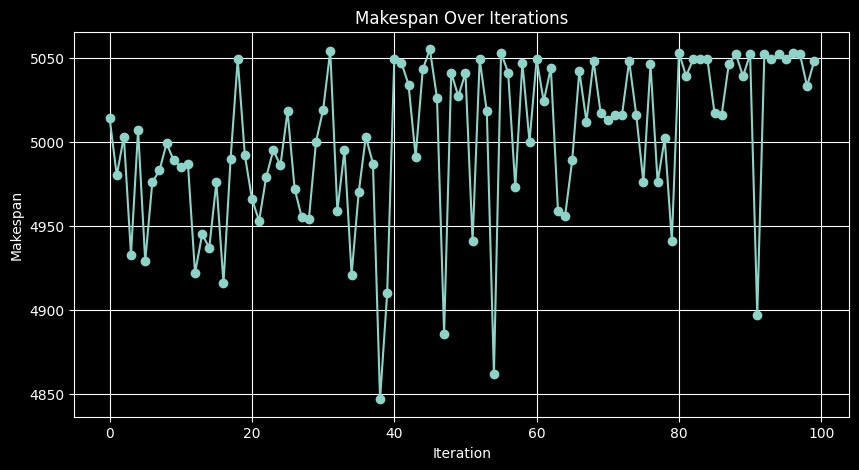

In [35]:
# Plot the makespan over iterations
plt.figure(figsize=(10, 5))
plt.plot(costs, marker='o')
plt.title('Makespan Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Makespan')
plt.grid(True)
plt.show()

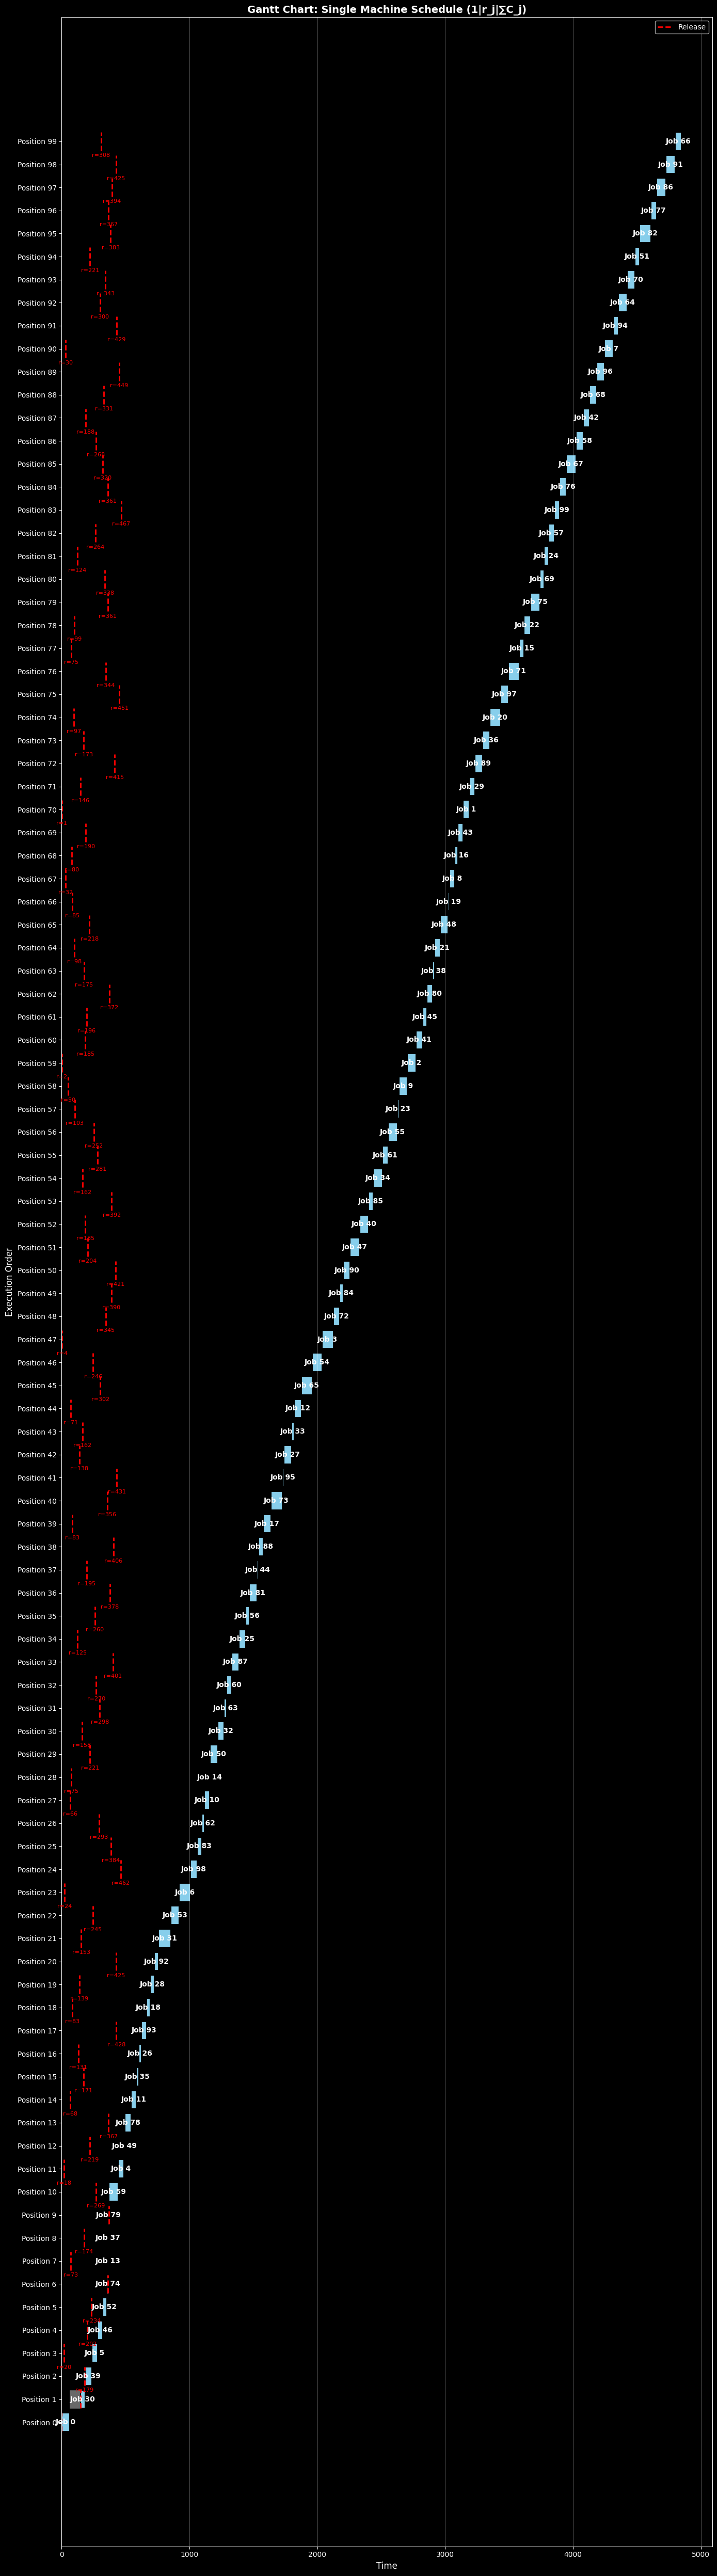

In [36]:
# Visualize the best schedule as a Gantt chart
plot_gantt(sequence, processing_times, release_dates)